# Tarea 3

Tomás González Villarroel


In [ ]:
import pandas as pd
import numpy as np

## 1. Implementación de Algoritmo

In [ ]:
class ClusterAglomerativo:
    
    def __init__(self, distance_metric, linkage, n_clusters, max_dist):
        self.distance_metric = distance_metric
        self.linkage = linkage
        self.n_clusters = n_clusters
        self.max_dist = max_dist
        self.cd_matrix = None
    
    def fit_predict(self, X):
        """
        Entrena al algoritmo con el DataFrame X y retorna los labels
        indicando el cluster al que pertenece cada dato.
        """
        distance_matrix = {i:[] for i in X.index} #np.zeros((X.shape[0], X.shape[0]))

        clusters_dict = {i:[i] for i in X.index} # dict de la forma indice: cluster
        linkages = {'complete': self.complete_linkage, 'centroid': self.centroid}

        new_cluster = None
        
        if self.n_clusters:
            n_clusters = len(distance_matrix)
            while n_clusters > self.n_clusters:
                
                if not new_cluster:
                    for key in distance_matrix:
                        cluster_actual = np.array([X.loc[i].to_numpy() for i in clusters_dict[key]])
                        distance_matrix[key] = np.array(list(map(lambda y: linkages[self.linkage](cluster_actual,
                                                    np.array([X.loc[i].to_numpy() for i in clusters_dict[y]])), distance_matrix.keys())))
                    llaves = list(distance_matrix.keys())
                    df_distances = pd.DataFrame(distance_matrix)
                    df_distances = df_distances.set_index([llaves])
                    self.cd_matrix = self.condensed_distance_matrix(np.array(list(df_distances.values)))
                else:
                    # Cuando un cluster cambia, se actualizan todas sus distancias 
                    cluster_actual = np.array([X.loc[i].to_numpy() for i in clusters_dict[new_cluster]])
                    serie_distancia = np.array(list(map(lambda y: linkages[self.linkage](cluster_actual,
                                                    np.array([X.loc[i].to_numpy() for i in clusters_dict[y]])), clusters_dict)))
                    df_distances[new_cluster] = serie_distancia
                    df_distances.loc[new_cluster] = df_distances[new_cluster]
                    

                if len(df_distances) <= 1:
                    break
                min_distance = min(self.condensed_distance_matrix(np.array(list(df_distances.values))))

                llaves = list(df_distances.columns)

                # Se juntan los clusters más cercanos
                #por_fusionar = {}
                cambiado = False
                for i in range(len(llaves)):
                    for j in range(i + 1, len(llaves)):
                        if not cambiado and df_distances.loc[llaves[i]][llaves[j]] == min_distance:
                            # for k, v in por_fusionar.items():
                            #     if llaves[i] == k or llaves[i] in v:
                            #         por_fusionar
                            cluster = clusters_dict[llaves[i]] + clusters_dict[llaves[j]]
                            # Se deja el id de cluster correspondiente al i-ésimo elemento
                            clusters_dict[llaves[i]] += clusters_dict[llaves[j]]
                            #distance_matrix.pop(llaves[j], None)
                            df_distances = df_distances.drop(llaves[j], axis=1)
                            df_distances = df_distances.drop(llaves[j])
                            clusters_dict.pop(llaves[j], None)

                            new_cluster = llaves[i]
                            cambiado = True
                            
                n_clusters = len(clusters_dict)
        else:
            while True:
                
                if not new_cluster:
                    for key in distance_matrix:
                        cluster_actual = np.array([X.loc[i].to_numpy() for i in clusters_dict[key]])
                        distance_matrix[key] = np.array(list(map(lambda y: linkages[self.linkage](cluster_actual,
                                                    np.array([X.loc[i].to_numpy() for i in clusters_dict[y]])), distance_matrix.keys())))
                    llaves = list(distance_matrix.keys())
                    df_distances = pd.DataFrame(distance_matrix)
                    df_distances = df_distances.set_index([llaves])
                else:
                    # Cuando un cluster cambia, se actualizan todas sus distancias 
                    cluster_actual = np.array([X.loc[i].to_numpy() for i in clusters_dict[new_cluster]])
                    serie_distancia = np.array(list(map(lambda y: linkages[self.linkage](cluster_actual,
                                                    np.array([X.loc[i].to_numpy() for i in clusters_dict[y]])), clusters_dict)))
                    df_distances[new_cluster] = serie_distancia
                    df_distances.loc[new_cluster] = df_distances[new_cluster]
                    

                if len(df_distances) <= 1:
                    break
                
                min_distance = min(self.condensed_distance_matrix(np.array(list(df_distances.values))))
                if min_distance >= self.max_dist:
                    break
                llaves = list(df_distances.columns)


                cambiado = False
                for i in range(len(llaves)):
                    for j in range(i + 1, len(llaves)):
                        if not cambiado and df_distances.loc[llaves[i]][llaves[j]] == min_distance:
                            cluster = clusters_dict[llaves[i]] + clusters_dict[llaves[j]]
                            clusters_dict[llaves[i]] += clusters_dict[llaves[j]]
                            df_distances = df_distances.drop(llaves[j], axis=1)
                            df_distances = df_distances.drop(llaves[j])
                            clusters_dict.pop(llaves[j], None)

                            new_cluster = llaves[i]
                            cambiado = True
            
        labels = []
        llaves_c = list(clusters_dict.keys())
        renamed_clusters = {i: clusters_dict[llaves_c[i]] for i in range(len(llaves_c))}
        item = 0
        for c in renamed_clusters.values():
            item+=len(c)
        for i in X.index:
            for key, value in renamed_clusters.items():
                if i in value:
                    labels.append(key)
        return labels
    
    def condensed_distance_matrix(self, matrix):
        """
        Retorna la matriz de distancia condensada a partir de matrix,
        siendo matrix un array de arrays.
        """
        condensed = []
        for i in range(matrix.shape[0]):
            for j in range(i + 1, matrix.shape[0]):
                condensed.append(matrix[i, j])
        return condensed
        
    
    def get_distance(self, p1, p2):
        """
        Obtiene la distancia entre los arrays p1 y p2.
        La métrica usada puede ser Euclidiana o Manhattan,
        dependiendo de lo especificado en el atributo self.distance_metric
        """
        if self.distance_metric == 'Manhattan':
            distances = sum(list(map(lambda c: abs(p1[c] - p2[c]), list(range(p1.shape[0])))))
        elif self.distance_metric == 'Euclidiana':
            distances = np.sqrt(sum(list(map(lambda c: (p1[c] - p2[c])**2, list(range(p1.shape[0]))))))
        else: 
            raise ValueError('Distancia no soportada')
        return distances
    
    def complete_linkage(self, clust1, clust2):
        """
        Recibe dos clusters (array de arrays) y retorna 
        la distancia entre ellos usando complete linkage
        """
        max_distance = 0
        if np.array_equal(clust1, clust2):
            return 0
        for p1 in clust1:
            for p2 in clust2:
                dist = self.get_distance(p1, p2)
                if  dist > max_distance:
                    max_distance = dist
        return max_distance
    
    def centroid(self, clust1, clust2):
        """
        Recibe dos clusters (array de arrays) y retorna 
        la distancia entre ellos usando centroid linkage
        """
        if np.array_equal(clust1, clust2):
            return 0
        mean1 = np.average(clust1, axis=0)
        mean2 = np.average(clust2, axis=0)
        return self.get_distance(mean1, mean2)
    
    
    

# 2. Aplicación de Algoritmo



In [ ]:
def preprocesamiento(path):
    '''
    Carga el archivo y preprocesa los datos.
    1. Elimina las columnas con demasiados valores únicos (>10)
    2. Elimina las filas con algún valor "?".
    3. Elimina valores NaN en caso de haber
    4. Hace One-Hot Encoding de columnas nominales
    5. Elimina columnas nominales
    6. Normaliza los datos
    '''
    df = pd.read_csv(path)

    # Se eliminan las columnas encounter_id, diag_1, diag_2, diag_3,
    # medical_specialty, payer_code, admission_source_id, patient_nbr,
    # discharge_disposition_id por contener demasiados valores únicos
    df = df.drop('diag_1', axis=1).drop('diag_2', axis=1).drop('diag_3', axis=1).drop('medical_specialty', axis=1)
    df = df.drop('payer_code', axis=1).drop('admission_source_id', axis=1).drop('patient_nbr', axis=1)
    df = df.drop('discharge_disposition_id', axis=1).drop('encounter_id', axis=1)

    #df = df.drop('weight', axis=1).drop('payer_code', axis=1).drop('medical_specialty', axis=1)
    for col in df.columns:
        df = df[df[col] != '?']
    #df = df[(df['race'] != '?') & (df['diag_1'] != '?') & (df['diag_2'] != '?') & (df['diag_3'] != '?')]
    df = df.dropna() 

    
    
    
    # One-Hot Encoding de columnas nominales
    df_objects = df.select_dtypes(['object'])
    df_ids = df[['admission_type_id']]
    df_objects = pd.concat([df_objects, df_ids], axis=1, sort=False)
    for i in df_objects.columns:
         values = df[i].unique()
         for v in values:
             new_col = df.apply(lambda x: 1 if x[i] == v else 0, axis=1)
             df[f'{i}_{v}'] = new_col
    
    # Se eliminan las columnas nominales
    df = df.select_dtypes(['number'])
    
    # Se elimina identificador nominal que fue pasado a one-hot encoding
    df = df.drop('admission_type_id', axis=1)
    
    # Quitamos columnas que solo tienen 1 valor
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df = df.drop(col, axis=1)
    
    # Normalizar datos
    df = df.apply(lambda x: (x - x.min())/(x.max()-x.min()))

    return df


Debido a los altos tiempos de ejecución del algoritmo implementado, se dejaron 500 filas del dataset original

In [ ]:
df = preprocesamiento('diabetic_data.csv')
df = df.head(500)

(101766, 41)
(3059, 41)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_data = pca.fit_transform(df)
df_reducido = pd.DataFrame(data=df_data, index=df.index, columns=['PCA_1', 'PCA_2'])


## Entrenamiento

Se probarán las siguientes configuraciones para cada *dataset*:

- `linkage='complete'`, `distance_metric='Euclidiana'` y `n_clusters=20`

- `linkage='centroid'`, `distance_metric='Euclidiana'` y `n_clusters=20`

- `linkage='complete'`, `distance_metric='Manhattan'` y `n_clusters=20`

Se decidió mantener constante el parámetro `n_clusters` para poder comparar de mejor forma los parámetros `linkage` y `distance_metric`.

In [ ]:
clustering_1 = ClusterAglomerativo('Euclidiana', 'complete', 20, None)
clustering_2 = ClusterAglomerativo('Euclidiana', 'centroid', 20, None)
clustering_3 = ClusterAglomerativo('Manhattan', 'complete', 20, None)
clustering_4 = ClusterAglomerativo('Euclidiana', 'complete', 20, None)
clustering_5 = ClusterAglomerativo('Euclidiana', 'centroid', 20, None)
clustering_6 = ClusterAglomerativo('Manhattan', 'complete', 20, None)

modelo_1 = clustering_1.fit_predict(df)
modelo_2 = clustering_2.fit_predict(df)
modelo_3 = clustering_3.fit_predict(df)

modelo_4 = clustering_4.fit_predict(df_reducido)
modelo_5 = clustering_5.fit_predict(df_reducido)
modelo_6 = clustering_6.fit_predict(df_reducido)

## Comparación de resultados

Se proceden a comparar los resultados usando `silhouette_score` de `sklearn`

In [ ]:
from sklearn.metrics import silhouette_score

print(f"Puntaje modelo 1: {silhouette_score(df, modelo_1, metric='euclidean')}")
print(f"Puntaje modelo 2: {silhouette_score(df, modelo_2, metric='euclidean')}")
print(f"Puntaje modelo 3: {silhouette_score(df, modelo_3, metric='manhattan')}")
print(f"Puntaje modelo 4: {silhouette_score(df_reducido, modelo_4, metric='euclidean')}")
print(f"Puntaje modelo 5: {silhouette_score(df_reducido, modelo_5, metric='euclidean')}")
print(f"Puntaje modelo 6: {silhouette_score(df_reducido, modelo_6, metric='manhattan')}")

Puntaje modelo 1: 0.09692049373776478
Puntaje modelo 2: -0.04057244036218269
Puntaje modelo 3: 0.13139433188211203
Puntaje modelo 4: 0.43527159392831083
Puntaje modelo 5: 0.4072977665540338
Puntaje modelo 6: 0.4467935954489785


Como resultado, se obtiene que todos los modelos que usaron el *dataset* reducido tuvieron mejor desempeño que los que no. La mejor combinación de parámetros se dio en un *dataset* reducido, escpecíficamente el sexto modelo, con valores `linkage='complete'`, `distance_metrid='Manhattan'` y `n_clusters=20`.

Para el *dataset* original, la mejor combinación fue usando el tercer modelo, con valores `linkage='complete'`, `distance_metrid='Manhattan'` y `n_clusters=20`, los cuales coinciden con los mejores parámetros para el *dataset* reducido.




# 4. Visualización

## Dendrograma

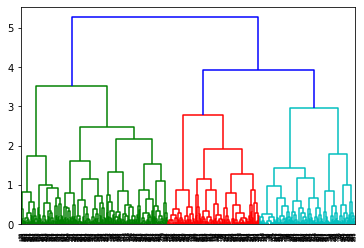

In [ ]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

linkage_matrix = hierarchy.linkage(clustering_6.cd_matrix, method=clustering_6.linkage)
plt.figure()
dendrogram = hierarchy.dendrogram(linkage_matrix)


## Clusters

Modelo 3 (La mejor combinación de parámetros con el *dataset* original):

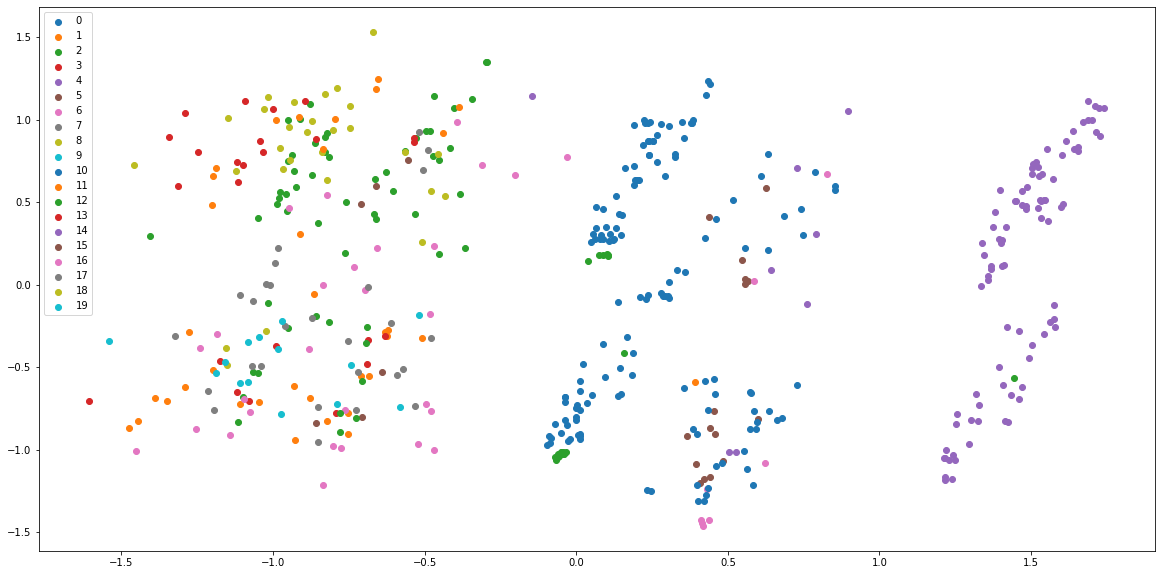

In [ ]:
df_reducido['label_3'] = modelo_3
fig, ax = plt.subplots(figsize=(20, 10))
for c in set(modelo_3):
    ax.scatter(df_reducido[df_reducido['label_3'] == c]['PCA_1'],
               df_reducido[df_reducido['label_3'] == c]['PCA_2'], label=c)
ax.legend()
plt.show()

Modelo 6 (La mejor combinación de parámetros con el dataset reducido):

In [ ]:
set(modelo_6)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

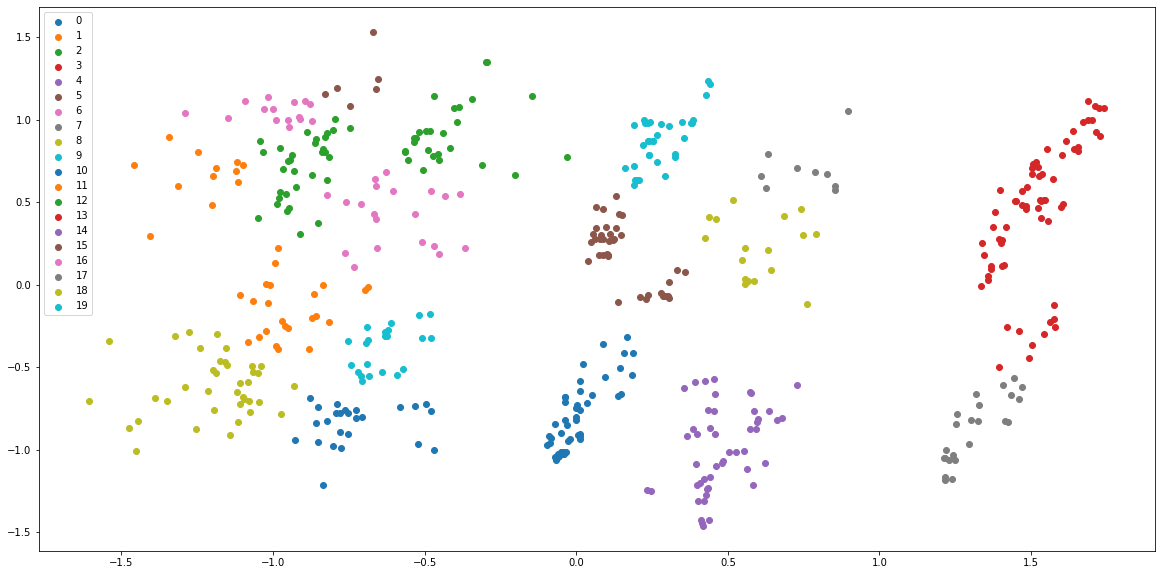

In [ ]:
df_reducido['label_6'] = modelo_6
fig, ax = plt.subplots(figsize=(20, 10))
for c in set(modelo_6):
    ax.scatter(df_reducido[df_reducido['label_6'] == c]['PCA_1'],
               df_reducido[df_reducido['label_6'] == c]['PCA_2'], label=c)
ax.legend()
plt.show()


# 5. Análisis

1. ¿Cómo trabajó los datos tipo `Nan` y datos defectuosos? 

    Se limpiaron usando `dropna` de `pandas`, y eliminando todas las filas que contenían algún valor `?` en sus datos.

2. ¿Utilizó todos los atributos o dejó algunos afuera? ¿Por qué?

    Se dejaron afuera los atributos `diag_1`, `diag_2`, `diag_3`, `medical_specialty`. En específico, se eliminaron todos los atributos nominales que tuvieran más de 10 valores distintos, pues al hacer *One-Hot Encoding* la dimensionalidad aumenta demasiado. 

3. ¿Qué diferencias observa al usar los diferentes parámetros? ¿Cuál resultó ser el más apropiado? ¿Por qué? Comente en función de la métrica calculada y la visualización.

    Se observa que la peor combinación de parámetros, tanto para el *dataset* original como el reducido, fue usando distancia Euclidiana y *linkage* de centroide. La combinación que resultó ser más apropiada en ambos *datasets* fue usando `linkage='complete'`, `distance_metrid='Manhattan'` y `n_clusters=20`, debido a que el puntaje obtenido fue el más cercano a 1, y obtener un *silhouette score* de 1 indica clusters densos y bien separados entre ellos.

4. ¿Qué observó al usar la métrica de evaluación Silhoutte Score? Comente.

    A partir de la métrica, observé que todos los puntajes estaban en el intervalo [-0.05, 0.5], lo que indica que existe cierta superposición entre clusters. Se observa que los valores para el *dataset* reducido indican que los clusters están mejor diferenciados que para el *dataset* sin reducir.

5. ¿Qué puede decir sobre la segmentación generada? ¿Existe algún tipo de paciente en particular que
resulta ser readmitido en el hospital? Comente y justifique gráficamente.

    Se puede decir que los pacientes que fueron clasificados con PC más altos están en clusters más separados que los con PC más bajos.
    Para responder a esta pregunta es de interés realizar un nuevo gráfico usando como colores el atributo `readmitted`:




In [ ]:
# Reconstruimos la columna readmitted a partir del encoding
def readmision(row):
    """
    Clasifica una fila según las columnas generadas por one-hot-encoding
    para readmision
    """
    if row['readmitted_>30']:
        return '>30'
    elif row['readmitted_<30']:
        return '<30'
    elif row['readmitted_NO']:
        return 'NO'
df_admitted = df.apply(readmision, axis=1)
df['readmitted'] = df_admitted

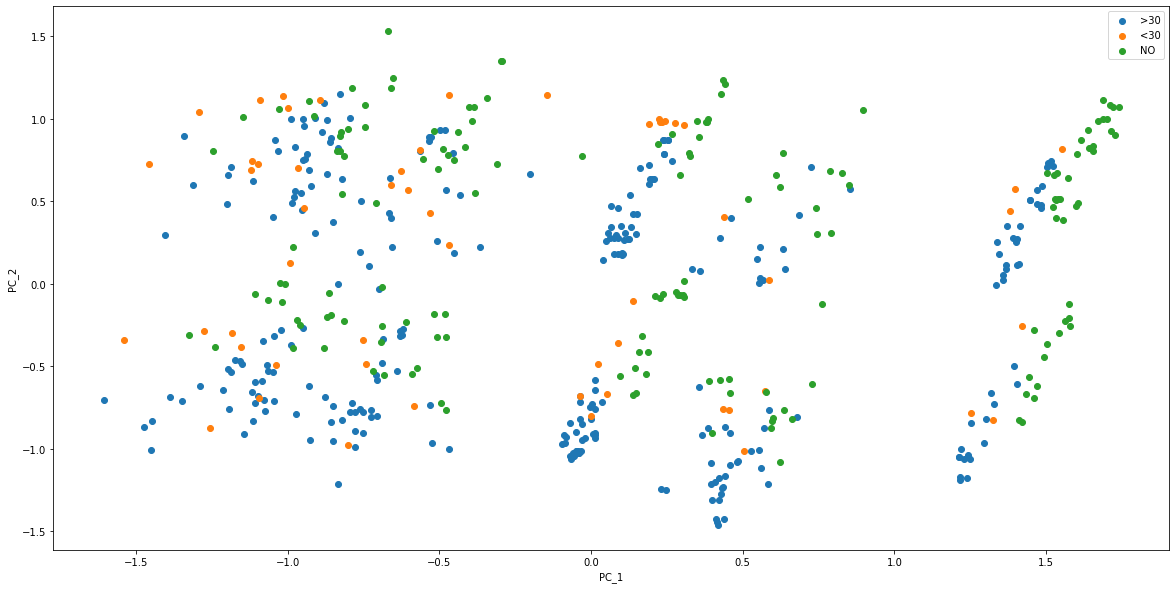

In [ ]:
df_reducido['readmitted'] = df_admitted
fig, ax = plt.subplots(figsize=(20, 10))
for c in set(df['readmitted'].values):
    ax.scatter(df_reducido[df_reducido['readmitted'] == c]['PCA_1'],
               df_reducido[df_reducido['readmitted'] == c]['PCA_2'], label=c)
ax.legend()
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.show()

A partir del gráfico, se observa que los pacientes con PC_1 más alto no fueron readmitidos en el hospital, y en general, los pacientes con PC_2 bajo sí fueron readmitidos y con tiempos mayores a 30 días.